In [2]:
import modelUtils as mu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark.sql.functions as F

from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql import Row
import pyspark.ml as ml


from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor

import scipy


from cern.nxcals.pyquery.builders import *

In [3]:
#Import our modelUtils library. The reload here is for when you make changes to the library but don't want to restart the kernel.
import modelUtils, importlib
importlib.reload(modelUtils)

<module 'modelUtils' from '/eos/home-i00/l/lgolino/SWAN_projects/GaussianConvolutionTest/modelUtils.py'>

In [4]:
#View the spark session.
spark

In [5]:
SPLIT_COUNT = 90
SPLIT_SIZE = 1024

In [6]:
data = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2022-05-05 06:00:00.000") \
            .endTime("2022-05-05 16:30:00.000") \
            .entity() \
            .parameter("PR.BGI82/ProfileAcquisition") \
            .buildDataset()


magnetData = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2022-05-05 06:00:00.000") \
            .endTime("2022-05-05 16:30:00.000") \
            .entity() \
            .parameter("RPACY.355.PR.RBGI82MAIN/MEAS.I.VALUE") \
            .buildDataset()


In [7]:
print(data.count())
print(magnetData.count())

3788
75601


In [8]:
data.printSchema()
magnetData.printSchema()

root
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- class: string (nullable = true)
 |-- cycleTimeWarningRF_ns: long (nullable = true)
 |-- cyclestamp: long (nullable = true)
 |-- device: string (nullable = true)
 |-- hardwareAcquisitionStatus: string (nullable = true)
 |-- hardwareOperationalMode: string (nullable = true)
 |-- hardwareSystemStatus: string (nullable = true)
 |-- measurementTimeOverThresholdFilter: long (nullable = true)
 |-- profileCount: integer (nullable = true)
 |-- profileFirstEventTimestamps_ns: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- dimensions: array (nullable = true)
 |    |    |-- element: integer (containsNull = true)
 |-- profileIntegrationTimes_ns: struct (nullable = true)
 |    |-- elements: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    

In [9]:
profile_data = data
magnet_data = magnetData

This is where we take the data pulled from NXCALS in the cells above and convert it into a useable dataframe for machine learning. The "cut" variable removes all profiles that have an unusually large or low number of hits. In my case I've set it to cut everything below 90% average (and therefore also about 110% average). This is quite strict but I had enough data to be strict on the number of hits, and the stricter you can be the cleaner you data is likely to be (not guaranteed but increases your odds of only using 'normal' profiles)

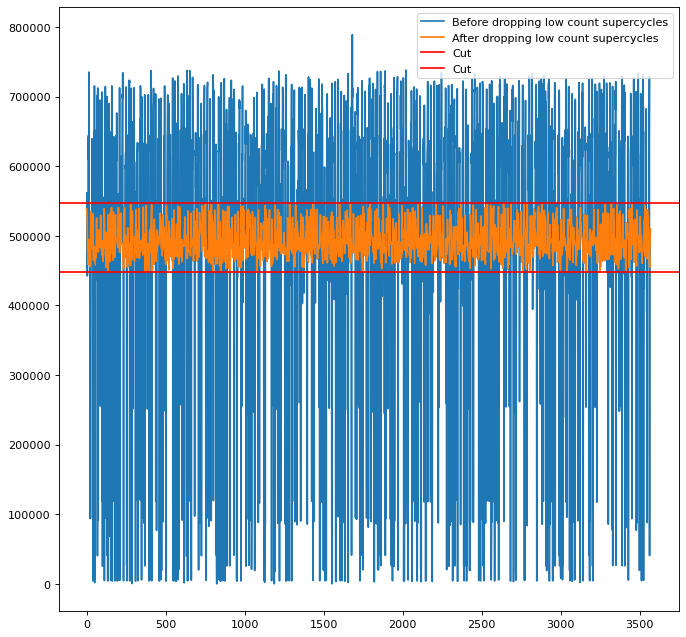

In [10]:
final_df = modelUtils.initate_df_from_datas(data, magnetData, 0.9)

In [11]:
#In this cell we do our diagnostics before moving on with the analysis.
#This is all turned off but hit each or all on if you want to see what we're working with up to this point.

#final_df.count() #Just to count the number of entries left
#final_df.limit(90).toPandas() #To see the first 90 profiles (ie first supercycle) in pandas dataframe
#final_df.groupBy('supercycle').count().show() #make sure there are 90 profiles per supercycle and see which ones were dropped
#final_df.describe().show() #General description

In [12]:
#More diagnostics
#Lets take a look at the first supercycle

#SPLIT_COUNT = data.select('profiles').withColumn("profiles", F.col("profiles").getField("dimensions") ).collect()[0][0][0] #90          - there are issues with collecting the dimensions like this so instead I just hard set it.
#SPLIT_SIZE = data.select('profiles').withColumn("profiles", F.col("profiles").getField("dimensions") ).collect()[0][0][1] #1024
SPLIT_COUNT = 90
SPLIT_SIZE = 1024


#pdf = final_df.filter(final_df.supercycle == 2) #If we want to look at supercycle number 2
pdf = final_df.filter(final_df.current == 18) #If we want to see profiles with a current of 18A (0.02T)

pdf = pdf.toPandas() #Convert it to pandas
#print(pdf)

#modelUtils.gif_that_df(pdf, 0, 'current18', SPLIT_COUNT, SPLIT_SIZE) #gif the first dataframe


Current 9:
Cycle 0:
<img src="current9.gif" width="400" align="left">
Cycle 1:
<img src="current9-1.gif" width="400" align="center">
Cycle 2:
<img src="current9-2.gif" width="400" align="right">
Cycle 5:
<img src="current9-5.gif" width="400" align="center">

In [13]:
modelUtils.gif_that_df(pdf, 5, 'current18-5', SPLIT_COUNT, SPLIT_SIZE)     #Gif the 5th
modelUtils.gif_that_df(pdf, 10, 'current18-10', SPLIT_COUNT, SPLIT_SIZE)   # /10th
modelUtils.gif_that_df(pdf, 15, 'current18-15', SPLIT_COUNT, SPLIT_SIZE)   # /and 15th supercycles

Current 18:

Cycle 0:
<img src="current18.gif" width="400" align="left">
Cycle 1:
<img src="current18-5.gif" width="400" align="center">
Cycle 2:
<img src="current18-10.gif" width="400" align="right">
Cycle 5:
<img src="current18-15.gif" width="400" align="center">

## Now we seperate and train

This has become a very interesting problem. It is essentially an unsupervised regression problem, but with the data that in theory *should* come from the prior distribution we can make some inferences to the solution.

We average all of our target data to give a single range which we use as the targer for each supercycle.

In [14]:
gr = final_df.groupBy("current").count()
gr.show()

+-------+-----+
|current|count|
+-------+-----+
|  176.0|44460|
|   88.0|29070|
|   44.0|24480|
|   18.0| 4950|
|    9.0|  270|
|   26.0|35550|
|   35.0|32850|
+-------+-----+



In [15]:
#First lets look at the data where the current was on max (176)
profiles_no_distortion = final_df.filter(final_df.current == 176)
profiles_no_distortion.count()
#profiles_no_distortion.show()
ydata = profiles_no_distortion.groupBy("cycle").mean().withColumnRenamed('avg(current)', 'current')
ydata.select(ydata.columns[:7]).show()
ydata.select(ydata.columns[:7]).count()
ydata = ydata.toPandas()

+-----+-------------------------+------------------+-------+----------+-------------------+--------------------+
|cycle|avg(__record_timestamp__)|   avg(supercycle)|current|avg(cycle)|avg(new_supercycle)|      avg(profiles0)|
+-----+-------------------------+------------------+-------+----------+-------------------+--------------------+
|    0|     1.651742307265181...|1822.1902834008097|  176.0|       0.0|  88057.53036437248|0.016194331983805668|
|    1|     1.651742307265181...|1822.1902834008097|  176.0|       1.0|  88058.53036437248| 0.02631578947368421|
|    2|     1.651742307265181...|1822.1902834008097|  176.0|       2.0|  88059.53036437248|0.016194331983805668|
|    3|     1.651742307265181...|1822.1902834008097|  176.0|       3.0|  88060.53036437248| 0.02834008097165992|
|    4|     1.651742307265181...|1822.1902834008097|  176.0|       4.0|  88061.53036437248|0.018218623481781375|
|    5|     1.651742307265181...|1822.1902834008097|  176.0|       5.0|  88062.53036437248|0.018

In [44]:
#This is a gif of the average profile at each cycle in the supercycle.
modelUtils.gif_that_df(ydata, 0, 'means', SPLIT_COUNT, SPLIT_SIZE)

<img src="means.gif" width="400" align="center">

In [17]:
#The centers are defined by the geometry of the detector. There is a variable: profileTransversePositions_um that contains this data but the effort required to pull and use that is greater than the benefit of using it. It's on the TODO.
centers = np.linspace(-28, 28, 1024)

#Here we calculate the std dev of each profile in the supercycle. This gives us (in this specific example) 90 std devs which correspond to the std dev of the average profiles.
ys = []
for i in range(len(ydata)):
    mean = np.average(centers, weights=ydata.iloc[i][-SPLIT_SIZE:])
    var = np.average((centers - mean)**2, weights=ydata.iloc[i][-SPLIT_SIZE:])
    std = np.sqrt(var)
    ys.append(std)

In [22]:
#here we decide which data to train on. In the current setup of this cell we take all data except where the current was 9, 18, 26, 35, or 176 (it wouldn't make sense to use this one anyway as its our target data).
#traindata = final_df.filter( final_df.current == 26 )
traindata = final_df.where( (F.col("current") != 9) & (F.col("current") != 18) & (F.col("current") != 26) & (F.col("current") != 35) & (F.col("current") != 176))

#Convert to pandas. Soon it may be necassary to train using the built in pyspark ML libraries. 
xdata = traindata.toPandas()
xdata = xdata.drop('__record_timestamp__', axis=1)
#xdata = xdata.drop('current', axis=1)
xdata = xdata.drop('supercycle', axis=1)
xdata = xdata.drop('new_supercycle', axis=1)

In [23]:
#Build the target data, essentially a repeating list of the average beam width at that stage in the cycle.
targetdata = pd.DataFrame(ys, columns=['y'])
newy = targetdata
for i in range(0, int(len(xdata)/90)-1):
    newy = newy.append(targetdata, ignore_index=True)
newy

,y
0,5.350526
1,5.314916
2,5.285262
3,5.260900
4,5.220333
...,...
53545,4.017254
53546,4.014353
53547,4.030315
53548,3.994737


In [24]:
len(newy) == len(xdata)

True

Finally lets split the data and train our models. here the orange is results on the training data, and blue on test data

In [25]:
#Split into train and test data. Shuffling here is important because if you use a range of values in V-IPM then the while last 20% of the set may have
#different beam parameters than the first 80%. Keeping the state consistent is important though.
X_train, X_test = train_test_split(xdata, test_size=0.8, shuffle=True, random_state=1)
y_train_stddev, y_test_stddev = train_test_split(newy, test_size=0.8, shuffle=True, random_state=1)

y    0.000975
dtype: float64
Score: 0.995281937739270 

Pearsons R corr for SD approach: 0.9971585723680743
Spearman R corr for SD approach: 0.9931050439866305
Kendall Tau R corr for SD approach: 0.9474250015945964


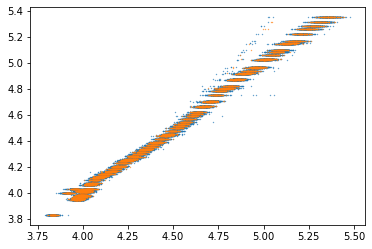

In [26]:
# Create linear regression object and train on stddevs.
# Model 1
regr_stddev = linear_model.LinearRegression(normalize = True)
regr_stddev.fit(X_train, y_train_stddev)
y_pred_stddev = regr_stddev.predict(X_test)
y_predtrain_stddev = regr_stddev.predict(X_train)

plt.scatter(y_pred_stddev, y_test_stddev, 0.1)
plt.scatter(y_predtrain_stddev, y_train_stddev, 0.1)
print(((y_pred_stddev - y_test_stddev)**2).mean())
print("Score: %.15f \n" % regr_stddev.score(X_train, y_train_stddev))

print('Pearsons R corr for SD approach:', scipy.stats.pearsonr(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )
print('Spearman R corr for SD approach:', scipy.stats.spearmanr(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )
print('Kendall Tau R corr for SD approach:', scipy.stats.kendalltau(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-n

y    0.000614
dtype: float64


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-n

Score: 0.999999999591308 

Pearsons R corr for SD approach: 0.9982156975805921
Spearman R corr for SD approach: 0.9956756780150908
Kendall Tau R corr for SD approach: 0.9597499385861087


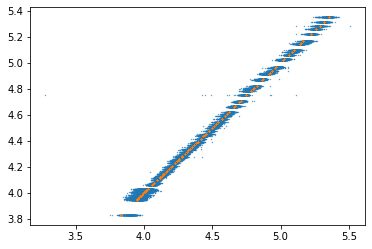

In [27]:
# Create linear regression object and train on stddevs.
# Model 1
regr_stddev = KernelRidge(alpha=10e-3, kernel='poly', gamma=None, degree=2)
regr_stddev.fit(X_train, y_train_stddev)
y_pred_stddev = regr_stddev.predict(X_test)
y_predtrain_stddev = regr_stddev.predict(X_train)

plt.scatter(y_pred_stddev, y_test_stddev, 0.1)
plt.scatter(y_predtrain_stddev, y_train_stddev, 0.1)
print(((y_pred_stddev - y_test_stddev)**2).mean())
print("Score: %.15f \n" % regr_stddev.score(X_train, y_train_stddev))


print('Pearsons R corr for SD approach:', scipy.stats.pearsonr(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )
print('Spearman R corr for SD approach:', scipy.stats.spearmanr(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )
print('Kendall Tau R corr for SD approach:', scipy.stats.kendalltau(np.array(y_test_stddev).flatten(), np.array(y_pred_stddev).flatten())[0] )

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/svm/base.py:928: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.026215332091949452
Score: 0.857498297995534 

Pearsons R corr for SD approach: 0.9817967379835223
Spearman R corr for SD approach: 0.9752626647261099
Kendall Tau R corr for SD approach: 0.8711406244560546


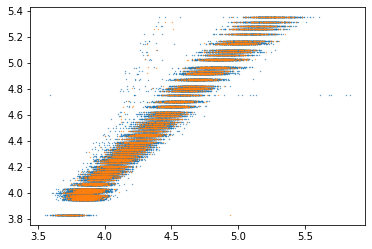

In [41]:
# Create linear regression object and train on stddevs.
# Model 1
regr_stddev = svm.LinearSVR(max_iter=50000)
regr_stddev.fit(X_train, y_train_stddev)
y_pred_stddev = regr_stddev.predict(X_test)
y_predtrain_stddev = regr_stddev.predict(X_train)

plt.scatter(y_pred_stddev, np.array(y_test_stddev).ravel(), 0.1)
plt.scatter(y_predtrain_stddev, y_train_stddev, 0.1)
print(((y_pred_stddev - np.array(y_test_stddev).ravel())**2).mean())
print("Score: %.15f \n" % regr_stddev.score(X_train, y_train_stddev))


print('Pearsons R corr for SD approach:', scipy.stats.pearsonr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Spearman R corr for SD approach:', scipy.stats.spearmanr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Kendall Tau R corr for SD approach:', scipy.stats.kendalltau(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.03834030196799637
Score: 0.781837855570990 

Pearsons R corr for SD approach: 0.9115986222675696
Spearman R corr for SD approach: 0.8965942539735737
Kendall Tau R corr for SD approach: 0.7166236472713217


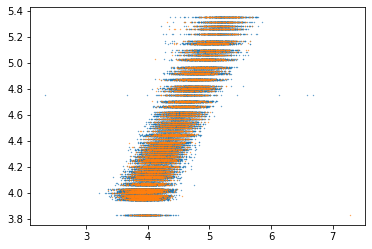

In [42]:
# Create linear regression object and train on stddevs.
# Create linear regression object and train on stddevs.
# Model 1
regr_stddev = MLPRegressor(hidden_layer_sizes=(200,170,140,110),activation="relu" ,solver='adam', batch_size=256, random_state=1, max_iter=20000)
regr_stddev.fit(X_train, y_train_stddev)
y_pred_stddev = regr_stddev.predict(X_test)

y_pred_stddev = regr_stddev.predict(X_test)
y_predtrain_stddev = regr_stddev.predict(X_train)

plt.scatter(y_pred_stddev, np.array(y_test_stddev).ravel(), 0.1)
plt.scatter(y_predtrain_stddev, y_train_stddev, 0.1)
print(((y_pred_stddev - np.array(y_test_stddev).ravel())**2).mean())
print("Score: %.15f \n" % regr_stddev.score(X_train, y_train_stddev))


print('Pearsons R corr for SD approach:', scipy.stats.pearsonr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Spearman R corr for SD approach:', scipy.stats.spearmanr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Kendall Tau R corr for SD approach:', scipy.stats.kendalltau(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.in

0.9894706676566166
{'activation': 'relu', 'batch_size': 8, 'hidden_layer_sizes': (200, 170, 140, 110), 'solver': 'adam'}
0.001390729789607479
Score: 0.989142115431073 

Pearsons R corr for SD approach: 0.9984070403762578
Spearman R corr for SD approach: 0.9976281421261053
Kendall Tau R corr for SD approach: 0.9710569409712769


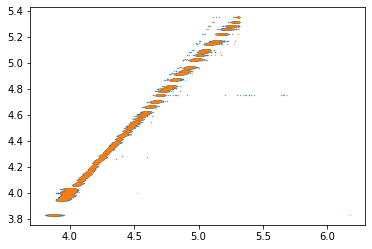

In [43]:
#Model 1
parameters = { 'hidden_layer_sizes':[(500,250,125,50,1), (400,200,100,50,1), (200,170,140,110)], 'activation':['relu'], 'solver':['adam'], 'batch_size':[8, 16, 32, 64]}

mlp_reg_std = MLPRegressor()
regr_stddev_grid = GridSearchCV(mlp_reg_std, parameters, n_jobs=-1, verbose=4)
regr_stddev_grid.fit(X_train, np.ravel(y_train_stddev))

regr_stddev = regr_stddev_grid.best_estimator_
print(regr_stddev_grid.best_score_)
print(regr_stddev_grid.best_params_)
y_pred_stddev = regr_stddev.predict(X_test)

y_pred_stddev = regr_stddev.predict(X_test)
y_predtrain_stddev = regr_stddev.predict(X_train)

plt.scatter(y_pred_stddev, np.array(y_test_stddev).ravel(), 0.1)
plt.scatter(y_predtrain_stddev, y_train_stddev, 0.1)
print(((y_pred_stddev - np.array(y_test_stddev).ravel())**2).mean())
print("Score: %.15f \n" % regr_stddev.score(X_train, y_train_stddev))


print('Pearsons R corr for SD approach:', scipy.stats.pearsonr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Spearman R corr for SD approach:', scipy.stats.spearmanr(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )
print('Kendall Tau R corr for SD approach:', scipy.stats.kendalltau(np.array(y_test_stddev).ravel(), y_pred_stddev)[0] )

#### ========================

L. GOLINO

lgolino@cern.ch

166064